In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


['/device:GPU:0']

In [2]:
import numpy as np
from skimage.transform import resize

class PreProcess:
    def crop(self, img):
        img_cropped = np.zeros((168, 148))
        img_cropped[:,:] = img[29:197,6:154]
        return img_cropped

    def to_grayscale(self, img):
        return np.mean(img, axis=2).astype(np.uint8)

    def downsample(self, img):
        return img[::2, ::2]

    # return [84, 84] frame shape
    def preprocess(self, img):
        return resize(self.downsample(self.crop(self.to_grayscale( img))), (84,84))

    def transform_reward(self, reward):
        return np.sign(reward)

In [3]:
from keras import backend as K
import keras


def fit_batch(model, target_model, start_states, actions, rewards, next_states, is_done, gamma = 0.99):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - target_model: The target DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions coend_staterresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_done: numpy boolean array of whether the resulting state is terminal
    
    """
    # convert to a 4-d array
    try:
        next_states = np.stack(next_states).swapaxes(1,2).swapaxes(2,3)
    except:
        for x in next_states:
            print(np.asarray(x).shape)
            

    # Predict the Q values of the next states. Passing ones as the mask.
#     next_Q_values = target_model.predict([next_states,  np.ones(actions.shape)])
    next_Q_values = target_model.predict(next_states)
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_done.astype(bool)] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Pass the actions as the mask and multiplying
    # the targets by the actions.

    # convert to a 4-d array
    start_states = np.stack(start_states).swapaxes(1,2).swapaxes(2,3)
    
    # Run one fast-forward to get the Q-values for all actions
    target = model.predict(start_states)
    target[actions.astype(bool)] = Q_values
    
    model.fit(
        [start_states], target,
        epochs=1, batch_size=len(start_states), verbose=0
    )
    
    
def get_epsilon_for_iteration(current_iteration, stable_iteration = 1000000 , initial_epsilon = 1, end_epsilon=0.1):
    '''
    decrease the epsilon linearly from 1 to 0.1 over the first million frames, and fixed at 0.1 thereafter
    '''
    epsilon = end_epsilon

    if current_iteration <= stable_iteration:
        decrease_per_epsilon = (initial_epsilon - end_epsilon) / stable_iteration
        epsilon = initial_epsilon - current_iteration * decrease_per_epsilon

    return epsilon

def choose_best_action(model, start_states, no_actions):
    # swap axes to archieve keras model input
    state = np.array(start_states).swapaxes(0,1).swapaxes(1,2)
    # extend to a 4-d array
    state = np.expand_dims(state, axis=0)
#     return model.predict([state, np.expand_dims(np.ones(no_actions), axis=0)]).argmax()
    return model.predict(state).argmax()

def q_iteration(env, model, target_model, agent, iteration, ring_buf, one_hot_encoder, pre_process):
    # Choose epsilon based on the iteration
    epsilon = get_epsilon_for_iteration(iteration)

    # Choose the action
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = choose_best_action(model, agent.end_states, env.action_space.n)

    # Play one game iteration (action X 4 times)
    agent.do_action(env, pre_process, action)
    ring_buf.append((agent.start_states, action, agent.total_reward, agent.end_states, agent.is_done))

    # Sample and fit
    batch = ring_buf.sample_batch(32)
    fit_batch(model, target_model, batch[0], onehot_encoder.transform(batch[1].reshape(-1,1)), 
              batch[2], batch[3], batch[4])
    
def huber_loss_simple(a, b):
    error = a - b
    if abs(error) > 1.0:
        return abs(error) - 1/2
    return error*error / 2

from keras import backend as K
# Note: pass in_keras=False to use this function with raw numbers of numpy arrays for testing
def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error*error / 2
    linear_term = abs(error) - 1/2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
        use_linear_term = K.cast(use_linear_term, 'float32')
    return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term


def evaluate(logger, model, agent, pre_process):

    print("Evaluation started.")
    for i in range(0, logger.evaluation_number):
        agent.reset_env(env, pre_process)

        while not agent.is_done:
            action = choose_best_action(model.model, agent.end_states, env.action_space.n)
            agent.do_action(env, pre_process, action)
            logger.write(agent)

Using TensorFlow backend.


In [ ]:
class Atari_Model1:
    # tensorflow backend
    def __create_model(self, n_actions, alpha = 0.00025):
        # tensorflow backend
        ATARI_SHAPE = (84, 84, 4)

        # With the functional API we need to define the inputs.
        frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')

        # Assuming that the input frames aimgre still encoded from 0 to 255. Transforming to [0, 1].
        normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)

        # "The first hidden layer convolves 16 8×8 filters with stride 4 with 
        #  the input image and applies a rectifier nonlinearity."
        conv_1 = keras.layers.convolutional.Convolution2D(16, 8, 8, subsample=(4, 4), activation='relu')(normalized)
        # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
        conv_2 = keras.layers.convolutional.Convolution2D(32, 4, 4, subsample=(2, 2), activation='relu')(conv_1)
        # Flattening the second convolutional layer.
        conv_flattened = keras.layers.core.Flatten()(conv_2)
        # "The final hidden layer is fully-connected and consists of 256 rectifier units."
        hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
        # "The output layer is a fully-connected linear layer with a single output for each valid action."
        output = keras.layers.Dense(n_actions)(hidden)

        model = keras.models.Model(input=[frames_input], output=output)
        optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
        model.compile(optimizer, loss='mse')
        
        return model
        
    def __init__(self, n_actions):
        self.n_actions = n_actions

        self.model = self.__create_model(self.n_actions)
        self.target_model = self.__create_model(self.n_actions)
        
    def copy_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [4]:
class Atari_Model2:
    # tensorflow backend
    def __create_model(self, n_actions, alpha = 0.00025):
        ATARI_SHAPE = (84, 84, 4)

        frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
#         actions_input = keras.layers.Input((self.n_actions,), name='filter')

        conv_1 = keras.layers.convolutional.Convolution2D(32, 8, 8, subsample=(4, 4), activation='relu'
        )(keras.layers.Lambda(lambda x: x / 255.0)(frames_input))
        conv_2 = keras.layers.convolutional.Convolution2D(64, 4, 4, subsample=(2, 2), activation='relu')(conv_1)
        conv_3 = keras.layers.convolutional.Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu')(conv_2)
        conv_flattened = keras.layers.core.Flatten()(conv_3)
        hidden = keras.layers.Dense(512, activation='relu')(conv_flattened)
        output = keras.layers.Dense(self.n_actions)(hidden)
#         filtered_output = keras.layers.multiply([output, actions_input])
        
#         model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
        model = keras.models.Model(input=[frames_input], output=output)
        optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
        model.compile(optimizer, loss=huber_loss)
        
        return model
        
    def __init__(self, n_actions):
        self.n_actions = n_actions

        self.model = self.__create_model(self.n_actions)
        self.target_model = self.__create_model(self.n_actions)
        
    def copy_model(self):
        self.target_model.set_weights(self.model.get_weights())

In [5]:
import random
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY
        # whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. 
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        self.size = size
        
    def append(self, element):
        self.data[self.end] = element
        
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def isFull(self):
        return len(self) == self.size
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
            
    def sample_batch(self, batch_size):
        result = []
        for x in range(batch_size):
            # generate random number between 0 and self.size-1
            result.append(self[random.randint(0,self.size-1)])
        return (np.asarray(result)).transpose()

In [6]:
class Logger:
    
    # Class for saving the performance indicators

    def __init__(self, evaluation_number):
        self.sum_ret = 0.0 # reward in one play
        self.total_ret = 0.0 # total reward in all plays
        self.evaluation_number = evaluation_number
        self.runs_in_eval = 0
        self.num_evals = 1 # counter
        self.max_return = 0
        self.min_return = 999999.9

    def write(self, agent):
        self.sum_ret += agent.total_reward
        self.total_ret += agent.total_reward
        if agent.is_done:
            print ("Evaluation " + str(self.runs_in_eval) + " :" + str(self.sum_ret))
            if self.sum_ret > self.max_return:
                self.max_return = self.sum_ret
            if self.sum_ret < self.min_return:
                self.min_return = self.sum_ret
            self.runs_in_eval += 1
            self.sum_ret = 0.0

            if self.runs_in_eval == self.evaluation_number:
                self.runs_in_eval = 0
                self.num_evals += 1
                avg = float(self.total_ret)/float(self.evaluation_number)
                print("Max reward : " + str(self.max_return) + "Min reward: " + str(self.min_return)\
                      + "Average reward in current episode: " + str(avg))
                f = open("model_learn_progress.txt", "a")
                f.write(str(agent.iteration)+","+str(avg)+","+str(self.max_return)+","\
                        +str(self.min_return)+"\n")
                self.total_ret = 0.0
                self.max_return = 0.0
                self.min_return = 999999.9

In [7]:
from IPython.core.debugger import set_trace
class Agent:
    # Class to save states

    def __init__(self):
        self.start_states = []
        self.end_states = []
        self.is_done = False
        self.total_reward = 0
        self.iteration = 0 # used for recording of iteration

        
    def reset_env(self, env, pre_process):
        # First learning trial
        frame = env.reset()
        state = pre_process.preprocess(frame)
        self.start_states = [state, state, state, state]
        self.end_states = self.start_states
        self.total_reward = 0
        self.is_done = False
        
    def do_action(self, env, pre_process, action):
        total_reward = 0
        # end_state is start_state1
        frame, reward, is_done, _ = env.step(action)
        state = pre_process.preprocess(frame)
        total_reward = total_reward + reward

#         frame, reward, is_done, _ = env.step(action)
#         state2 = pre_process.preprocess(frame)
#         total_reward = total_reward + reward
        
#         frame, reward, is_done, _ = env.step(action)
#         state3 = pre_process.preprocess(frame)
#         total_reward = total_reward + reward
        
#         frame, reward, is_done, _ = env.step(action)
#         state4 = pre_process.preprocess(frame)
#         total_reward = total_reward + reward
        
        self.start_states = self.end_states.copy()
        self.end_states.pop(0)
        self.end_states.append(state)
        self.is_done = is_done
        self.total_reward = pre_process.transform_reward(total_reward)

In [8]:
from keras.models import model_from_yaml
def save_model(model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("atari_dqn_model.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("atari_dqn_model.h5")
    print("Saved model to disk")

In [41]:
def evaluate_random(logger, model, agent, pre_process):

    print("Evaluation started.")
    for i in range(0, logger.evaluation_number):
        agent.reset_env(env, pre_process)

        while not agent.is_done:
            action = env.action_space.sample()
            agent.do_action(env, pre_process, action)
            logger.write(agent)
logger = Logger(5)
evaluate_random(logger, model, agent, pre_process)

Evaluation started.


/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Evaluation 0 :3.0
Evaluation 1 :2.0
Evaluation 2 :0.0
Evaluation 3 :1.0
Evaluation 4 :1.0
Max reward : 3.0Min reward: 0.0Average reward in current episode: 1.4


In [9]:
# Import the gym module
import gym
from sklearn.preprocessing import OneHotEncoder


onehot_encoder = OneHotEncoder(sparse=False)

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

# Render
# env.render()

frames = []
rewards = []
ring_buf_size = 100000
ring_buf = RingBuf(ring_buf_size)
model = Atari_Model2(4)
pre_process = PreProcess()
logger = Logger(10)
agent = Agent()

iteration = 1 # initialize counter
max_iter = 1000000 # total of iterations
iter_loop = 10000 # copy model every this value

# First enrich the whole ring_buf
while not ring_buf.isFull():
    agent.reset_env(env, pre_process)
    
    while not agent.is_done:
        # Perform a random action, returns the new frame, reward and whether the game is over
        action = env.action_space.sample()
        agent.do_action(env, pre_process, action)
        
        ring_buf.append((agent.start_states, action, agent.total_reward, agent.end_states, agent.is_done))
        if(len(ring_buf) % 10000 == 0):
            print("ring buf size: ", len(ring_buf),"/",ring_buf_size)
        
print("Enriched ring buf, ", len(ring_buf),"isFull: ",  ring_buf.isFull())

onehot_encoder.fit((np.asarray(ring_buf.data)).transpose()[1].reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), activation="relu", strides=(4, 4))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.


ring buf size:  10000 / 100000
ring buf size:  20000 / 100000
ring buf size:  30000 / 100000
ring buf size:  40000 / 100000
ring buf size:  50000 / 100000
ring buf size:  60000 / 100000
ring buf size:  70000 / 100000
ring buf size:  80000 / 100000
ring buf size:  90000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  100000 / 100000
ring buf size:  1

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [11]:
max_iter = 20000000
iter_loop = 100000
update_model_loop = 10000

while iteration < max_iter:
    agent.reset_env(env, pre_process)
    
    while not agent.is_done:
        # Iterate with DQN
        q_iteration(env, model.model, model.target_model, agent, iteration, 
                    ring_buf, onehot_encoder, pre_process)


        iteration = iteration + 1
        if(iteration == max_iter):
            break
        else:
            if(iteration%update_model_loop == 0):
                model.copy_model()
                # save model weights in yml, h5
                save_model(model.model)
            if(iteration%iter_loop == 0):
                print("Progess : ", iteration,"/",max_iter)
                agent.iteration = iteration
                # evaluate and save stat in file
                evaluate(logger, model, agent, pre_process)
    # Render
#     env.render()

/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Progess :  10100000 / 20000000
Evaluation started.
Evaluation 0 :1.0
Evaluation 1 :1.0
Evaluation 2 :1.0
Evaluation 3 :1.0
Evaluation 4 :1.0
Evaluation 5 :1.0
Evaluation 6 :1.0
Evaluation 7 :1.0
Evaluation 8 :1.0
Evaluation 9 :1.0
Max reward : 1.0Min reward: 1.0Average reward in current episode: 1.0
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Progess :  10200000 / 20000000
Evaluation started.
Evaluation 0 :0.0
Evaluation 1 :0.0
Evaluation 2 :0.0
Evaluation 3 :0.0
Evaluation 4 :0.0
Evaluation 5 :0.0
Evaluation 6 :0.0
Evaluation 7 :0.0
Evaluation 8 :0.0
Evaluation 9 :0.0
Max reward : 0.0Min reward: 0.0Average reward in current episode: 0.

Saved model to disk
Progess :  11700000 / 20000000
Evaluation started.
Evaluation 0 :0.0
Evaluation 1 :0.0
Evaluation 2 :0.0
Evaluation 3 :0.0
Evaluation 4 :0.0
Evaluation 5 :0.0
Evaluation 6 :0.0
Evaluation 7 :0.0
Evaluation 8 :0.0
Evaluation 9 :0.0
Max reward : 0.0Min reward: 0.0Average reward in current episode: 0.0
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Progess :  11800000 / 20000000
Evaluation started.
Evaluation 0 :1.0
Evaluation 1 :1.0
Evaluation 2 :1.0
Evaluation 3 :1.0
Evaluation 4 :1.0
Evaluation 5 :1.0
Evaluation 6 :1.0
Evaluation 7 :1.0
Evaluation 8 :1.0
Evaluation 9 :1.0
Max reward : 1.0Min reward: 1.0Average reward in current episode: 1.0
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to dis

KeyboardInterrupt: 

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
        for i in mylist:
            print(i)

def get_epsilon_for_iteration(current_iteration, stable_iteration = 1000000 , initial_epsilon = 1, end_epsilon=0.1):
    '''
    decrease the epsilon linearly from 1 to 0.1 over the first million frames, and fixed at 0.1 thereafter
    '''

    epsilon = end_epsilon

    if current_iteration <= stable_iteration:
        decrease_per_epsilon = (initial_epsilon - end_epsilon) / stable_iteration
        epsilon = initial_epsilon - current_iteration * decrease_per_epsilon

    return epsilon


if __name__ == '__main__':
    epsilons = []
    for i in range(2000000):
        epsilons.append(get_epsilon_for_iteration(i))

    plt.plot(epsilons)
    plt.ylabel('epsilon')
    plt.xlabel('time step')
    plt.show()

Writing decay_epsilon.py


In [29]:
# np.equal(agent.end_states[2], agent.end_states[3]) 
env.spec

In [13]:
agent.reset_env(env, pre_process)
# swap axes to archieve keras model input
state = np.array(agent.end_states).swapaxes(0,1).swapaxes(1,2)
# extend to a 4-d array
state = np.expand_dims(state, axis=0)
print(state)
model.model.predict([state])

[[[[133.54761905 133.54761905 133.54761905 133.54761905]
   [142.         142.         142.         142.        ]
   [142.         142.         142.         142.        ]
   ...
   [142.         142.         142.         142.        ]
   [142.         142.         142.         142.        ]
   [133.54761905 133.54761905 133.54761905 133.54761905]]

  [[133.54761905 133.54761905 133.54761905 133.54761905]
   [142.         142.         142.         142.        ]
   [142.         142.         142.         142.        ]
   ...
   [142.         142.         142.         142.        ]
   [142.         142.         142.         142.        ]
   [133.54761905 133.54761905 133.54761905 133.54761905]]

  [[133.54761905 133.54761905 133.54761905 133.54761905]
   [ 25.35714286  25.35714286  25.35714286  25.35714286]
   [  0.           0.           0.           0.        ]
   ...
   [  0.           0.           0.           0.        ]
   [ 25.35714286  25.35714286  25.35714286  25.35714286]
   [13

/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


array([[0.3105371 , 0.3095994 , 0.31099385, 0.30627292]], dtype=float32)

In [50]:
env.close()

In [49]:
# Import the gym module
import gym

# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
# Reset it, returns the starting frame
# frame = env.reset()
agent.reset_env(env, pre_process)
# Render
env.render()

while not agent.is_done:
    action = choose_best_action(model.model, agent.start_states, env.action_space.n)
    agent.do_action(env, pre_process, action)
#     frame, reward, is_done, _ = env.step(env.action_space.sample())
    print(agent.is_done)
    # Render
    env.render()


/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laikasin93/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

KeyboardInterrupt: 

(83, 74)


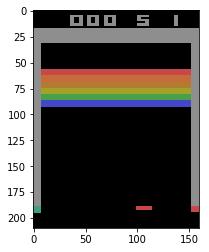

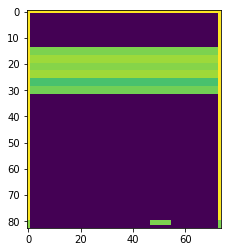

In [24]:
pre_process = PreProcess()

import matplotlib.pyplot as plt
import gym
# Create the environment and display the initial state
env = gym.make('BreakoutDeterministic-v4')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe)


fig,ax = plt.subplots()
frame_processed = pre_process.preprocess(firstframe)
im = ax.imshow(pre_process.preprocess(firstframe))
print(frame_processed.shape)



In [4]:
env.env.close()

import string
for x in range(10):
    ring_buf.append((''.join(random.choices(string.ascii_uppercase + string.digits, k=5)), x))

In [2]:

 

 
# load YAML and create model
yaml_file = open('atari_dqn_model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("atari_dqn_model.h5")
print("Loaded model from disk")
# compile the loaded model before further use

Loaded model from disk
